## Introduce

## Import and setting

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader
from scipy.stats import anderson

import time
import warnings

grey = .77, .77, .77
matplotlib.rcParams['figure.figsize'] = (24.0, 10.0)

print('set up complete!')

set up complete!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Fit distribution with data and cacul loss

In [0]:
# Create models from data
def fit_distribution(data, DISTRIBUTIONS, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0   

    good_dists = []

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        # plt.plot(x, pdf, label='{}'.format(distribution.name))                     
                        pd.Series(pdf, x).plot(ax=ax, label='{}'.format(distribution.name))
                        pass
                    end
                except Exception:
                    pass
                 
                good_dists.append((distribution.name, sse))

        except Exception:
            pass


    return good_dists

### Choose good distribution

In [0]:
# Create models from data
def good_distribution(data, DISTRIBUTIONS, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0   

    # Compute norm sse:
    norm_loc, norm_scale = st.norm.fit(data)
    norm_pdf = st.norm.pdf(x, loc=norm_loc, scale=norm_scale)
    norm_sse = np.sum(np.power(y - norm_pdf, 2.0))
    norm_dist = [(st.norm, norm_sse)]

    # Distribution is fitter than norm
    more_than_norm_dists = []
    more_than_norm_params = []

    # Distribution is not as fit as norm
    less_than_norm_dists = []
    less_than_norm_params = []

    # best & worst distribution
    best_distributions = []
    worst_distributions = []

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        # plt.plot(x, pdf, label='{}'.format(distribution.name))                     
                        pd.Series(pdf, x).plot(ax=ax, label='{}'.format(distribution.name))
                        pass
                    end
                except Exception:
                    pass
                 
                # identify if this distribution is better
                if norm_sse > sse > 0:
                    more_than_norm_dists.append((distribution, sse))
                    more_than_norm_params.append(params)

                # identify if this distribution is worse
                if sse > norm_sse > 0:
                    less_than_norm_dists.append((distribution, sse))
                    less_than_norm_params.append(params)

                # print('huyyyyy')
                  

        except Exception:
            pass

    

   # compute best distribution is fitter than norm
    best_sses = sorted([sse for dist, sse in more_than_norm_dists])
    if len(best_sses) == 1:
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[0]]
    elif len(best_sses) == 2:
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[0]] 
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[1]]
    elif len(best_sses) > 2:
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[0]] 
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[1]]
        # best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[2]] 

    # compute best distribution is not as fit as norm
    worst_sses = sorted([sse for dist, sse in less_than_norm_dists])
    if len(worst_sses) == 1:
        worst_distributions += [(dist, sse) for dist, sse in less_than_norm_dists if sse == worst_sses[0]]
    elif len(worst_sses) > 1:
        worst_distributions += [(dist, sse) for dist, sse in less_than_norm_dists if sse == worst_sses[0]] 
        # worst_distributions += [(dist, sse) for dist, sse in less_than_norm_dists if sse == worst_sses[1]]

    return (best_distributions + worst_distributions + norm_dist)

### Compute VaR

In [0]:
def compute_VaR(distribution, data, date, n_days_calc_var=250, level_meaning=0.05, n_iters = 10, last_k_days = 1):

    n_days = data.shape[0]
    var_monte = []

    n_error = -1
    loss_accuracy = -1.0
    last_var = 0

    loss_lastkdays =  -1.0
    tssl = pd.DataFrame()
    
    try:
        # Ignore warnings from data that can't be fit
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            
            for i in range(0, n_days - n_days_calc_var):
                var_1_time = []
                
                params = distribution.fit(data.iloc[i : i+n_days_calc_var])
                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                for _ in range(n_iters):
                    # Calculate fitted PDF and error with fit in distribution
                    monte_carlo = distribution.rvs(loc=loc, scale=scale, size = n_days_calc_var, *arg, random_state=None)
                    serie = pd.Series(monte_carlo)            
                    var_1_time.append(serie.quantile(level_meaning))

                var_monte.append(sum(var_1_time) / n_iters)

            var_monte_array = np.array(var_monte)
            tssl_array = np.array(data.iloc[n_days_calc_var:n_days])

            if last_k_days == 0:
                loss_accuracy = np.round(sum(var_monte_array > tssl_array) / (len(var_monte_array) * level_meaning), 3)
                n_error = sum(var_monte_array > tssl_array)
               
            elif last_k_days > 0:
                loss_accuracy = np.round(sum(var_monte_array[0:-last_k_days] > tssl_array[0:-last_k_days]) / (len(var_monte_array) * level_meaning), 3)
                n_error = sum(var_monte_array[0:-last_k_days] > tssl_array[0:-last_k_days]) 
                loss_lastkdays = np.round(sum(var_monte_array[-1: -last_k_days-1:-1] > tssl_array[-1: -last_k_days-1:-1]) , 3) / last_k_days
            
            tssl['Date'] = pd.Series(np.array(date.iloc[n_days_calc_var:n_days]))
            tssl['Monte_carlo'] = pd.Series(var_monte_array)
            tssl['TSSL'] = pd.Series(tssl_array)
            tssl['Error'] = tssl['Monte_carlo'] > tssl['TSSL']
            last_var = var_monte_array[-1-last_k_days-1]
            
            
    except Exception:
        pass

    return (loss_accuracy, n_error, last_var), loss_lastkdays, tssl
    

## Value at risk

### Read data & preprocessing


In [7]:
vnindex = pd.read_csv("/content/drive/My Drive/value_at_risk/excel_^vnindex.csv")
# vnindex = pd.read_csv("excel_^vnindex.csv")

# Add profit rate column
profit_rate = []
for i in range(len(vnindex)-1):
    profit_rate.append(vnindex.Close[i] / vnindex.Close[i+1] - 1)
profit_rate.append(0)
vnindex['Profit_rate'] = profit_rate
if vnindex.Profit_rate.isnull().any() or vnindex.Date.isnull().any():
    print('add profit rate column badly')
else:
    print('add profit rate column successfully')

add profit rate column successfully


In [8]:
# Get data
data = vnindex.loc[(vnindex.Date > 20100000) & (vnindex.Date < 20200000)]
print(len(data))
# Describe data
data.describe()

2492


,Date,OpenFixed,HighFixed,LowFixed,CloseFixed,Volume,Open,High,Low,Close,VolumeDeal,VolumeFB,VolumeFS,Profit_rate
count,2.492000e+03,2492.000000,2492.000000,2492.000000,2492.000000,2.492000e+03,2492.000000,2492.000000,2492.000000,2492.000000,2492.0,2.492000e+03,2.492000e+03,2492.000000
mean,2.014569e+07,636.955674,640.829286,632.988965,636.900437,1.014293e+08,636.955674,640.829286,632.988965,636.900437,0.0,3.289945e+07,3.313677e+07,0.000328
std,2.874236e+04,208.082258,209.044583,206.867724,208.129371,6.242054e+07,208.082258,209.044583,206.867724,208.129371,0.0,1.176856e+08,1.099889e+08,0.011056
min,2.010010e+07,334.930000,339.320000,332.280000,336.730000,1.051255e+07,334.930000,339.320000,332.280000,336.730000,0.0,0.000000e+00,0.000000e+00,-0.058717
25%,2.012071e+07,480.850000,483.662500,476.990000,480.070000,4.508689e+07,480.850000,483.662500,476.990000,480.070000,0.0,3.792697e+06,3.178522e+06,-0.005164
50%,2.015011e+07,572.715000,576.400000,569.505000,572.355000,9.632140e+07,572.715000,576.400000,569.505000,572.355000,0.0,6.758400e+06,6.285784e+06,0.000719
75%,2.017071e+07,768.252500,770.385000,764.422500,768.505000,1.433075e+08,768.252500,770.385000,764.422500,768.505000,0.0,1.173116e+07,1.151412e+07,0.006541
max,2.019123e+07,1207.620000,1211.340000,1197.440000,1204.330000,4.459405e+08,1207.620000,1211.340000,1197.440000,1204.330000,0.0,2.147484e+09,1.846567e+09,0.045031


In [9]:
data.iloc[:-1000]

,Ticket,Date,OpenFixed,HighFixed,LowFixed,CloseFixed,Volume,Open,High,Low,Close,VolumeDeal,VolumeFB,VolumeFS,Profit_rate
66,^VNINDEX,20191231,965.71,965.71,958.22,960.99,185242663,965.71,965.71,958.22,960.99,0,9060758,12607698,-0.004186
67,^VNINDEX,20191230,962.89,967.52,962.47,965.03,177740545,962.89,967.52,962.47,965.03,0,9691230,6699440,0.001578
68,^VNINDEX,20191227,957.70,963.51,954.19,963.51,180524101,957.70,963.51,954.19,963.51,0,11593310,9954430,0.005133
69,^VNINDEX,20191226,960.67,962.11,957.43,958.59,265937347,960.67,962.11,957.43,958.59,0,13883180,9027620,-0.002425
70,^VNINDEX,20191225,958.18,962.83,957.50,960.92,238316843,958.18,962.83,957.50,960.92,0,4874990,5780130,0.002127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,^VNINDEX,20140110,518.33,523.06,518.24,518.94,92706120,518.33,523.06,518.24,518.94,0,4173240,2333080,0.003791
1554,^VNINDEX,20140109,513.66,516.98,513.52,516.98,88973710,513.66,516.98,513.52,516.98,0,6782260,3803190,0.005993
1555,^VNINDEX,20140108,511.03,514.20,509.01,513.90,68649490,511.03,514.20,509.01,513.90,0,4707960,3940350,0.007410
1556,^VNINDEX,20140107,510.84,513.00,509.87,510.12,71634380,510.84,513.00,509.87,510.12,0,3869560,3447770,0.002004


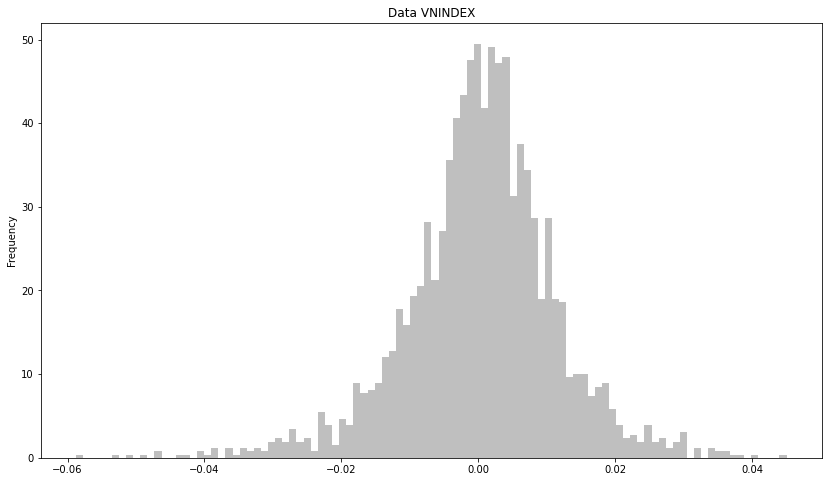

In [10]:
matplotlib.rc('figure', figsize=(14, 8))
ax = data.Profit_rate.plot(kind='hist', bins=100, density=True, alpha=0.5, color='grey', 
                           edgecolor='none', title='Data VNINDEX')
plt.show()

### Anderson test vnindex


In [11]:
from scipy.stats import anderson
(statistic, critical_values, significance_level) = anderson(data.Profit_rate, dist='norm')
# result = anderson(data)
print('Statistic: %.3f' % statistic)
p = 0
for i in range(len(critical_values)):
	sl, cv = significance_level[i], critical_values[i]
	if statistic < critical_values[i]:
		print('%.3f: %.3f, data looks normal' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal' % (sl, cv))

Statistic: 16.513
15.000: 0.575, data does not look normal
10.000: 0.655, data does not look normal
5.000: 0.786, data does not look normal
2.500: 0.917, data does not look normal
1.000: 1.090, data does not look normal


### Fit distribution

In [13]:
# Find best fit distribution
DISTRIBUTIONS = [st.t, st.logistic, st.dgamma, st.laplace, st.hypsecant,
                 st.dweibull, st.pearson3, st.gumbel_l, st.gumbel_r, st.norm]



good_dists_sses = fit_distribution(data.Profit_rate, DISTRIBUTIONS, 500)

good_dists_sorted = sorted([(dist, sse) for dist, sse in good_dists_sses], key=lambda x: x[1])
fit_dists = pd.DataFrame({'vnindex': [dist for dist, sse in good_dists_sorted]})
fit_dists['vnindex lost square'] = pd.DataFrame([sse for dist, sse in good_dists_sorted])
fit_dists.to_csv('vnindex_fit.csv')
fit_dists

,vnindex,vnindex lost square
0,dweibull,10038.246495
1,hypsecant,10074.862111
2,t,10173.233882
3,dgamma,10360.533857
4,logistic,11190.507166
5,laplace,11606.170565
6,pearson3,15856.056916
7,norm,16324.650925
8,gumbel_l,26473.078680
9,gumbel_r,38377.356768


### Choose good distributions


In [0]:
# Do this with vnindex
good_dists_sses = []
for i in range(10):
    dist = good_distribution(data.Profit_rate, DISTRIBUTIONS, 500)
    good_dists_sses += dist

good_dists = [dist for dist, sse in good_dists_sses]
sses = [sse for dist, sse in good_dists_sses]
good_dists = list(set(good_dists))

for dist in good_dists:
    print(dist.name)

norm
dweibull
hypsecant
gumbel_r
laplace
gumbel_l
logistic
dgamma
t
pearson3


### Plot data with good distributions

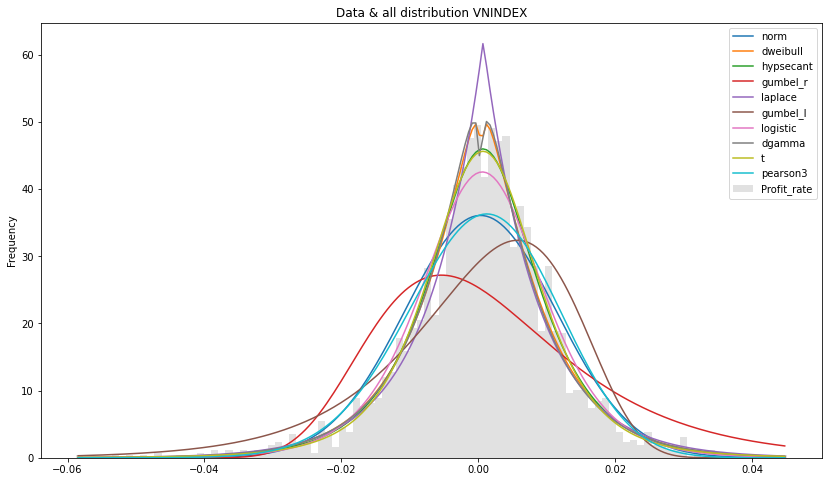

In [0]:
matplotlib.rc('figure', figsize=(14, 8))
ax = data.Profit_rate.plot(kind='hist', bins=100, density=True, alpha=0.5, color=grey, 
                           edgecolor='none', title='Data & all distribution VNINDEX')
dist = good_distribution(data.Profit_rate, good_dists, 200, ax=ax)
plt.legend(loc='best')
plt.show()

### Compute VaR and VR test

In [0]:
start_time = time.time()

last_k_days = 0
level_meanings = [0.05, 0.01]
n_iters = 100
n_days_calc_var = 1000

result = pd.DataFrame({'Distribution':[dist.name for dist in good_dists]})
result['N_days'] = pd.Series([data.shape[0] - n_days_calc_var for dist in good_dists])

tssl= {}
tssl[0.05] = {}
tssl[0.01] = {}

print('Data: Vnindex')
print('Date: {} to {}'.format(data.Date.iloc[-1], data.Date.iloc[0]))
print('----------------------------------------------')

for level_meaning in level_meanings:
    vr_losses = []
    n_errors = [] 
    last_vars = []
    
    for dist in good_dists:
        (vr_loss, n_error, last_var), _, tssl[level_meaning][dist.name] = compute_VaR(dist, data.Profit_rate.iloc[::-1], data.Date.iloc[::-1], n_days_calc_var=n_days_calc_var, 
                                                                                 n_iters = n_iters, level_meaning=level_meaning, last_k_days = last_k_days)
        vr_losses.append(vr_loss)
        n_errors.append(n_error)
        last_vars.append(last_var)

    result['VR loss {}%'.format(level_meaning*100)] = pd.Series(vr_losses)
    result['Number error VaR {}%'.format(level_meaning*100)] = pd.Series(n_errors)
    result['Last VaR {}%'.format(level_meaning*100)] = pd.Series(last_vars)

print('total time train: {} (s)'.format(time.time() - start_time))
print('VR test loss_accuracy with monte carlo {} times :'.format(n_iters))
result['Last VaR Point 1%'] = (result['Last VaR {}%'.format(0.01*100)] + 1) * data.Close.iloc[1]
result['Last VaR Point 5%'] = (result['Last VaR {}%'.format(0.05*100)] + 1) * data.Close.iloc[1]
result['Last profit rate Point '] = data.Close.iloc[0]
result


Data: Vnindex
Date: 20100104 to 20191231
----------------------------------------------
total time train: 3147.639538049698 (s)
VR test loss_accuracy with monte carlo 100 times :


,Distribution,N_days,VR loss 5.0%,Number error VaR 5.0%,Last VaR 5.0%,VR loss 1.0%,Number error VaR 1.0%,Last VaR 1.0%,Last VaR Point 1%,Last VaR Point 5%,Last profit rate Point
0,norm,1492,0.871,65,-0.014985,2.011,30,-0.021142,944.627344,950.569434,960.99
1,dweibull,1492,0.871,65,-0.014643,1.542,23,-0.024312,941.568431,950.898771,960.99
2,hypsecant,1492,0.885,66,-0.013721,1.609,24,-0.022684,943.139072,951.788390,960.99
3,gumbel_r,1492,0.536,40,-0.018195,1.743,26,-0.023289,942.555501,947.471296,960.99
4,laplace,1492,0.818,61,-0.014352,1.005,15,-0.024950,940.952806,951.179559,960.99
5,gumbel_l,1492,0.295,22,-0.024647,0.335,5,-0.040529,925.918131,941.244859,960.99
6,logistic,1492,0.885,66,-0.013520,1.743,26,-0.021582,944.202577,951.982316,960.99
7,dgamma,1492,0.858,64,-0.014433,1.475,22,-0.024396,941.487380,951.101663,960.99
8,t,1492,0.898,67,-0.013344,1.408,21,-0.025402,940.515883,952.152675,960.99
9,pearson3,1492,0.845,63,-0.015412,1.743,26,-0.022246,943.561539,950.157031,960.99


### Plot result

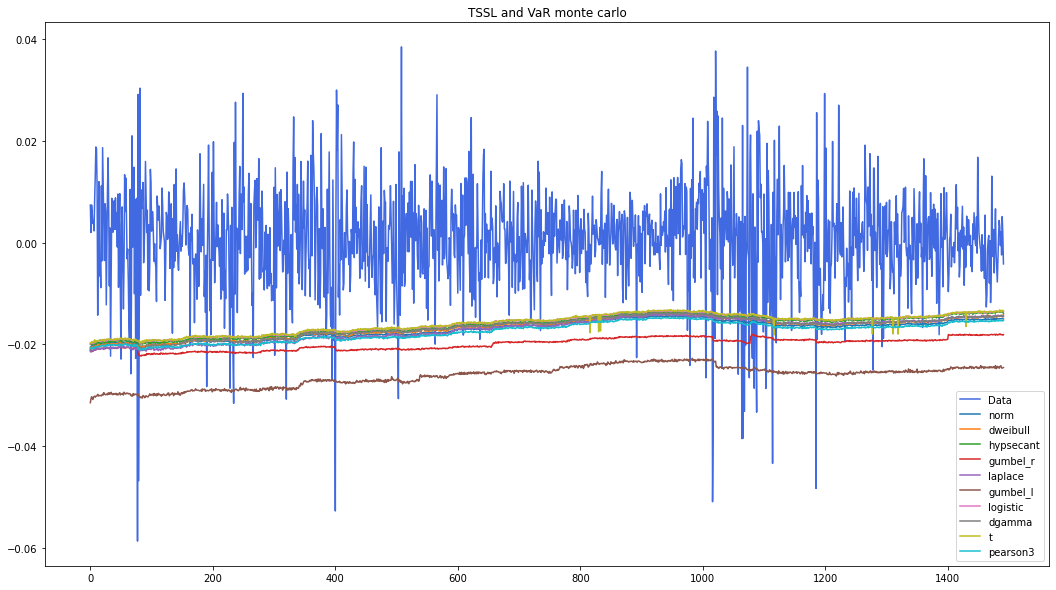

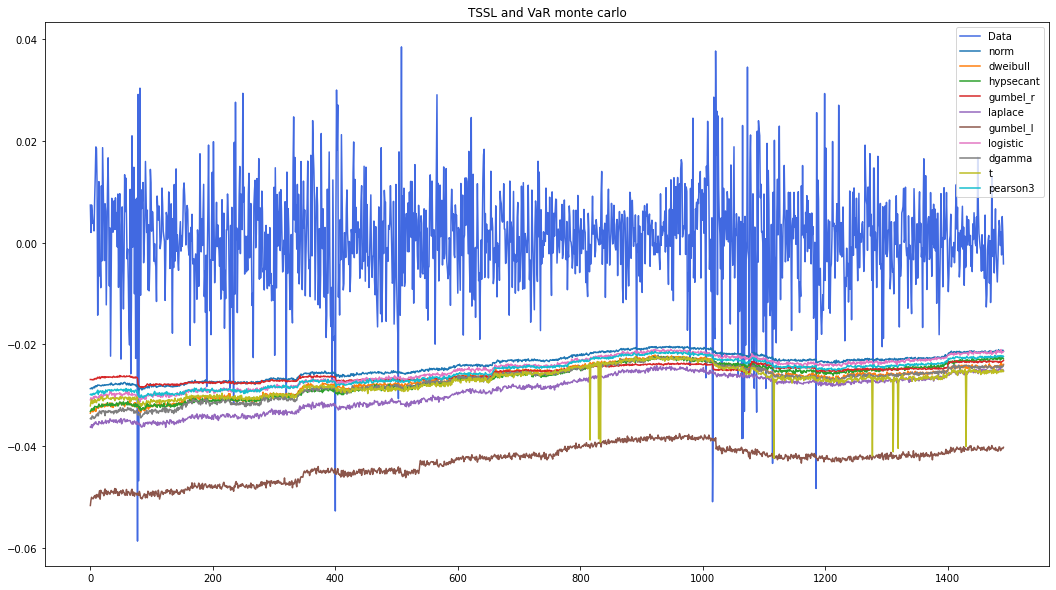

In [0]:

# Adjusting the size of matplotlib
import matplotlib as mpl
# matplotlib.style.use('default')
mpl.rc('figure', figsize=(18, 10))
mpl.__version__

# Adjusting the style of matplotlib



# .Profit_rate.iloc[1001:].plot(label='hi', color='royalblue')
# plt.legend()

for level_meaning in level_meanings:
    ax = data.iloc[:len(tssl[0.05][st.norm.name])].iloc[::-1].set_index(np.arange(len(tssl[0.05][st.norm.name]))).Profit_rate.plot(title='TSSL and VaR monte carlo', label='Data', color='royalblue')

    for dist in good_dists:
        tssl[level_meaning][dist.name].Monte_carlo.plot(ax = ax, label='{}'.format(dist.name))
    plt.legend(loc='best')
    plt.show()

### Save result

In [0]:
data[['Date', 'Close', 'Profit_rate']].describe().to_csv('vnindex_describe.csv')
result.to_csv('vnindex_result.csv')
for level_meaning in level_meanings:
    for dist in good_dists:
        tssl[level_meaning][dist.name].to_csv('huyto/vnindex_{}%_{}.csv'.format(level_meaning, dist.name))
!zip -r /content/huyto.zip /content/huyto

  adding: content/huyto/ (stored 0%)
  adding: content/huyto/vnindex_0.01%_gumbel_l.csv (deflated 61%)
  adding: content/huyto/vnindex_0.05%_logistic.csv (deflated 61%)
  adding: content/huyto/vnindex_0.01%_logistic.csv (deflated 61%)
  adding: content/huyto/vnindex_0.05%_hypsecant.csv (deflated 61%)
  adding: content/huyto/vnindex_0.05%_t.csv (deflated 61%)
  adding: content/huyto/vnindex_0.05%_norm.csv (deflated 61%)
  adding: content/huyto/vnindex_0.05%_pearson3.csv (deflated 61%)
  adding: content/huyto/vnindex_0.05%_gumbel_r.csv (deflated 61%)
  adding: content/huyto/vnindex_0.05%_dweibull.csv (deflated 61%)
  adding: content/huyto/vnindex_0.01%_hypsecant.csv (deflated 61%)
  adding: content/huyto/vnindex_0.01%_norm.csv (deflated 61%)
  adding: content/huyto/vnindex_0.01%_t.csv (deflated 61%)
  adding: content/huyto/vnindex_0.01%_pearson3.csv (deflated 61%)
  adding: content/huyto/vnindex_0.05%_gumbel_l.csv (deflated 61%)
  adding: content/huyto/vnindex_0.05%_laplace.csv (deflated

In [0]:
# # Load result to edit
# result = pd.read_csv('/content/drive/My Drive/value_at_risk/ket_qua/vnindex_result.csv')
# result['Last VaR Point 1%'] = (result['Last VaR 1.0%'] + 1) * data.Close.iloc[1]
# result['Last VaR Point 5%'] = (result['Last VaR 5.0%'] + 1) * data.Close.iloc[1]
# result['Last profit rate Point '] = data.Close.iloc[0]
# result.to_csv('/content/drive/My Drive/value_at_risk/ket_qua/vnindex_result.csv')
# result